# Model `PNL-PF` vs `BinaryMFPenalty`

`PNL-PF` is an upgrade of `BinaryMFPenalty` with linear link function being replaced with sigmoid link function. This makes the series of methods more friendly with overlapped data.

To better show the improvement, we use synthetic data with greater overlapping and `k` equal to the order of the synthetic matrix.

In [20]:
# use project files rather than the installed PyBMF

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[I] m            : 300
[I] n            : 500
[I] k            : 5
[I] overlap      : 2
[I] seed         : 1000
[I] noise        : 2
[I] seed         : 2000
[I] Using RandomState.


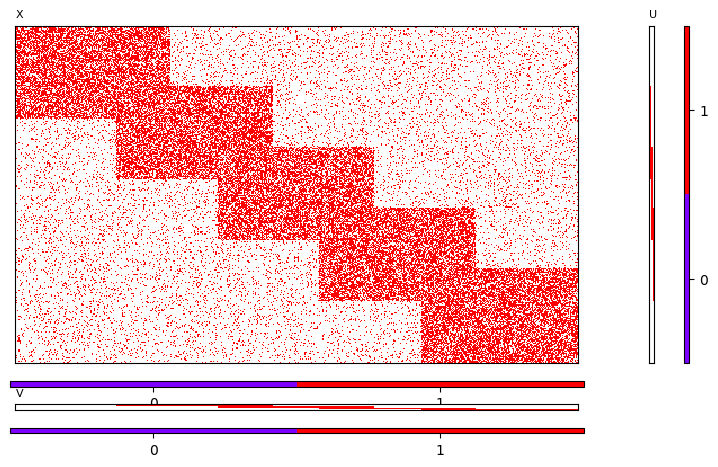

<Figure size 640x480 with 0 Axes>

In [21]:
# generating synthetic data

from PyBMF.generators import BlockDiagonalMatrixGenerator

data = BlockDiagonalMatrixGenerator(m=300, n=500, k=5, overlap=[0.35, 0.35])
data.generate(seed=1000)
data.add_noise(noise=[0.4, 0.1], seed=2000)

data.show_matrix(scaling=0.5)

In [22]:
# # loading real-world data

# from PyBMF.datasets import MovieLensData

# data = MovieLensData(size="100k")
# data.load()

# idx = data.sample(factor_id=0, n_samples=300, seed=1000)
# idx = data.sample(factor_id=1, n_samples=500, seed=1000)

# data.show_matrix(scaling=0.5)

In [23]:
# splitting the data into train, validation and test

from PyBMF.datasets import RatioSplit, NoSplit

# split = RatioSplit(X=data.X, val_size=0.1, test_size=0.2, seed=1997)
split = NoSplit(X=data.X)

# split.negative_sample(
#     train_size=split.pos_train_size, 
#     val_size=split.pos_val_size, 
#     test_size=split.pos_test_size, 
#     seed=2023, type='popularity')
split.negative_sample(
    size=split.pos_size, 
    seed=2023, type='popularity')

X_train, X_val, X_test = split.X_train, split.X_val, split.X_test

[I] NoSplit, sampling positives
[I] RatioSplit, sampling positives
[I]   seed         : 1722766551
[I]   train_size   : 43288
[I]   val_size     : 0
[I]   test_size    : 0
[I]   seed         : 1722766551
[I] RatioSplit, sampling negatives
[I]   seed         : 2023
[I]   all_negatives: 106712
[I]   n_negatives  : 43288
[I]   train_size   : 43288
[I]   val_size     : 0
[I]   test_size    : 0
[I]   seed         : 2023


In [24]:
# shared parameters

k = 5
W = 'full'
task = 'reconstruction'

# Init `U`, `V` with NMF

[I] k            : 5
[I] U            : None
[I] V            : None
[I] beta_loss    : frobenius
[I] init_method  : nndsvd
[I] solver       : cd
[I] tol          : 0.0001
[I] max_iter     : 1000
[I] seed         : 2024
[I] verbose      : False
[I] display      : False
[I] save_model   : False
[I] Missing validation data.
[W] Missing testing data.
[I] name         : 2024-08-04 18-15-51-514674 NMFSklearn
[I] U, V existed. Skipping initialization.
[I] time elapsed :  0s


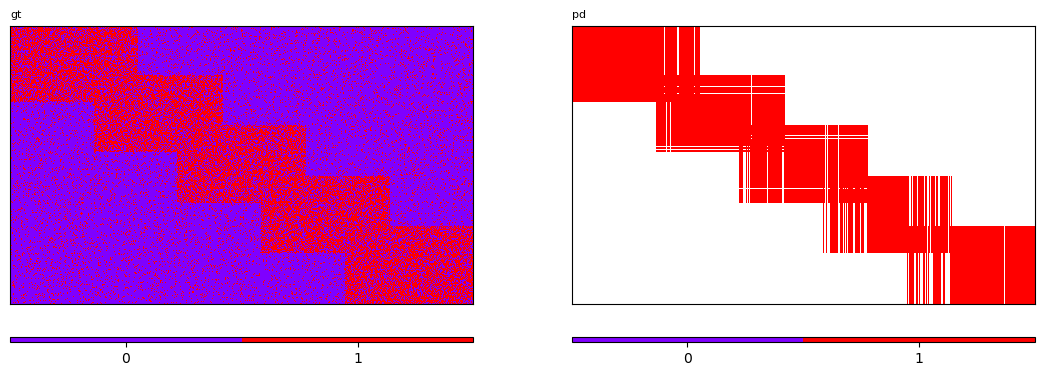

<Figure size 640x480 with 0 Axes>

In [25]:
from PyBMF.models import NMFSklearn, WNMF
from PyBMF.utils import show_factor_distribution

model_nmf = NMFSklearn(k=k, init_method='nndsvd', max_iter=1000, seed=2024)
model_nmf.fit(X_train=X_train, save_model=False)

# model_nmf = WNMF(k=k, W=W, beta_loss='frobenius', init_method='normal', max_iter=1000, seed=2024)
# model_nmf.fit(X_train=X_train, task='reconstruction', verbose=False, display=False, show_logs=False, show_result=True, save_model=False)

In [26]:
# shared parameters

U, V = model_nmf.U.copy(), model_nmf.V.copy()

reg = 1
reg_growth = 1.02
max_iter = 10
min_diff = 1e-3
tol = 0
link_lamda = 5
init_method = 'custom' # 'custom', 'uniform', 'normal'

# `BinaryMFPenalty`

[I] k            : 5
[I] U            : (300, 5)
[I] V            : (500, 5)
[I] W            : full
[I] reg          : 1
[I] beta_loss    : frobenius
[I] solver       : mu
[I] reg_growth   : 1.02
[I] max_reg      : 10000000000.0
[I] tol          : 0
[I] min_diff     : 0.001
[I] max_iter     : 10
[I] init_method  : custom
[I] normalize_method : balance
[I] seed         : 2024
[I] verbose      : False
[I] display      : False
[I] task         : reconstruction
[I] save_model   : False
[I] Missing validation data.
[W] Missing testing data.
[I] name         : 2024-08-04 18-15-51-990820 BinaryMFPenalty
[I] Normalized from: U: [0.0000, 1.1932], V: [0.0000, 1.0349]
[I]              to: U: [0.0000, 1.0043], V: [0.0000, 1.0043]


[I] error: 1.05e+04, rec_error: 1.04e+04, reg: 1.22e+00, reg_error: 3.39e+01: : 11it [00:00, 18.43it/s]                      


[W] Stopped in advance: Reach maximum iteration
[I] time elapsed :  0s


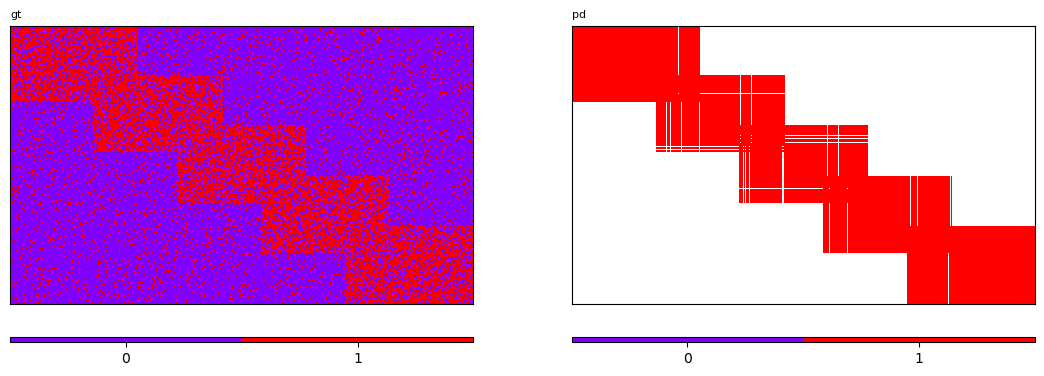

\
                                                                              
                 time iter         error     rec_error       reg  reg_error   
0   04/08/24 06:15:52    0  10474.495318  10446.315845  1.000000  28.179474   
1   04/08/24 06:15:52    1  10474.411502  10446.344222  1.000000  28.067280   
2   04/08/24 06:15:52    2  10474.945253  10446.367303  1.020000  28.577950   
3   04/08/24 06:15:52    3  10475.500334  10446.385078  1.040400  29.115256   
4   04/08/24 06:15:52    4  10476.070319  10446.398816  1.061208  29.671503   
5   04/08/24 06:15:52    5  10476.653323  10446.410095  1.082432  30.243229   
6   04/08/24 06:15:52    6  10477.248715  10446.419920  1.104081  30.828795   
7   04/08/24 06:15:52    7  10477.856304  10446.428879  1.126162  31.427426   
8   04/08/24 06:15:52    8  10478.476091  10446.437323  1.148686  32.038767   
9   04/08/24 06:15:52    9  10479.108169  10446.445477  1.171659  32.662691   
10  04/08/24 06:15:52   10  10479.752684  10446.453491  1.195093  33.299193   
11  04/08/24 06:15:52   11  10480.409812  10446.461471  1.218994  33.948341   

       train            
           0            
        RMSE       MAE  
0   0.373208  0.280133  
1   0.373209  0.279878  
2   0.373209  0.279752  
3   0.373209  0.279684  
4   0.373209  0.279642  
5   0.373210  0.279613  
6   0.373210  0.279591  
7   0.373210  0.279573  
8   0.373210  0.279558  
9   0.373210  0.279543  
10  0.373210  0.279529  
11  0.373211  0.279516

train                              
                              0                              
                 time    Recall Precision  Accuracy        F1
0   04/08/24 06:15:52  0.749030  0.643895  0.808027  0.692495
1   04/08/24 06:15:52  0.749030  0.643895  0.808027  0.692495
2   04/08/24 06:15:52  0.749030  0.643895  0.808027  0.692495
3   04/08/24 06:15:52  0.749030  0.643895  0.808027  0.692495
4   04/08/24 06:15:52  0.749030  0.643895  0.808027  0.692495
5   04/08/24 06:15:52  0.749030  0.643895  0.808027  0.692495
6   04/08/24 06:15:52  0.749030  0.643895  0.808027  0.692495
7   04/08/24 06:15:52  0.749030  0.643895  0.808027  0.692495
8   04/08/24 06:15:52  0.749030  0.643895  0.808027  0.692495
9   04/08/24 06:15:52  0.747852  0.644047  0.807953  0.692078
10  04/08/24 06:15:52  0.747852  0.644047  0.807953  0.692078
11  04/08/24 06:15:52  0.747852  0.644047  0.807953  0.692078

<Figure size 640x480 with 0 Axes>

In [27]:
from PyBMF.models import BinaryMFPenalty

model_bmfp = BinaryMFPenalty(k=k, U=U, V=V, W=W, reg=reg, reg_growth=reg_growth, init_method='custom', max_iter=max_iter, min_diff=min_diff, tol=tol, seed=2024)
model_bmfp.fit(X_train=X_train, X_val=None, X_test=None, task=task, verbose=False, display=False, save_model=False)

# `PNL-PF`

[I] k            : 5
[I] U            : (300, 5)
[I] V            : (500, 5)
[I] W            : full
[I] reg          : 1
[I] beta_loss    : frobenius
[I] solver       : mu
[I] link_lamda   : 5
[I] reg_growth   : 1.02
[I] max_reg      : 10000000000.0
[I] tol          : 0
[I] min_diff     : 0.001
[I] max_iter     : 10
[I] init_method  : custom
[I] normalize_method : balance
[I] seed         : 2024
[I] verbose      : False
[I] display      : False
[I] task         : reconstruction
[I] save_model   : False
[I] Missing validation data.
[W] Missing testing data.
[I] name         : 2024-08-04 18-15-53-249742 PNLPF
[I] Normalized from: U: [0.0000, 1.0043], V: [0.0000, 1.0043]
[I]              to: U: [0.0000, 1.0043], V: [0.0000, 1.0043]


[I] error: 1.05e+04, rec_error: 1.04e+04, reg: 1.22e+00, reg_error: 3.40e+01: : 11it [00:00, 13.25it/s]                      


[W] Stopped in advance: Reach maximum iteration
[I] time elapsed :  0s


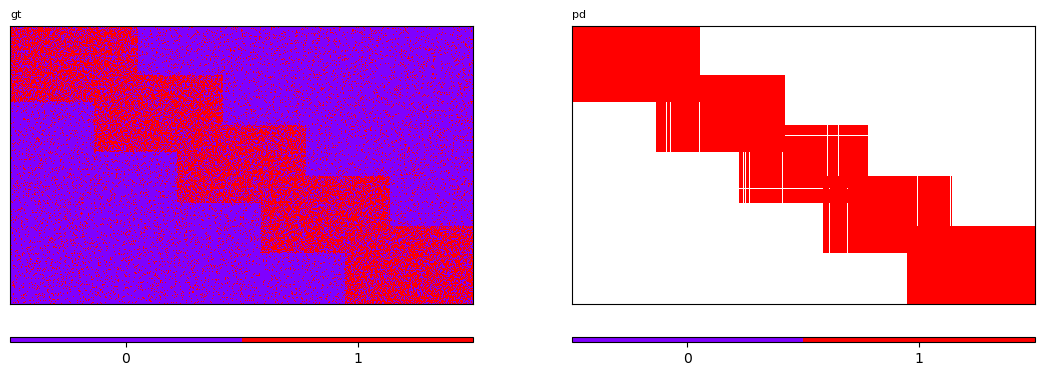

\
                                                                              
                 time iter         error     rec_error       reg  reg_error   
0   04/08/24 06:15:53    0  10501.915339  10473.735865  1.000000  28.179474   
1   04/08/24 06:15:53    1  10474.100640  10445.789171  1.000000  28.311469   
2   04/08/24 06:15:53    2  10469.164692  10440.412830  1.020000  28.751862   
3   04/08/24 06:15:53    3  10466.698316  10437.452304  1.040400  29.246011   
4   04/08/24 06:15:53    4  10465.050213  10435.275548  1.061208  29.774665   
5   04/08/24 06:15:53    5  10463.895276  10433.565214  1.082432  30.330061   
6   04/08/24 06:15:53    6  10463.086424  10432.179292  1.104081  30.907132   
7   04/08/24 06:15:53    7  10462.535121  10431.032495  1.126162  31.502626   
8   04/08/24 06:15:53    8  10462.182585  10430.068152  1.148686  32.114433   
9   04/08/24 06:15:54    9  10461.987810  10429.246618  1.171659  32.741192   
10  04/08/24 06:15:54   10  10461.921230  10428.539191  1.195093  33.382040   
11  04/08/24 06:15:54   11  10461.960971  10427.924522  1.218994  34.036449   

       train            
           0            
        RMSE       MAE  
0   0.373697  0.287770  
1   0.373199  0.286800  
2   0.373103  0.286074  
3   0.373050  0.285548  
4   0.373011  0.285141  
5   0.372980  0.284815  
6   0.372955  0.284547  
7   0.372935  0.284322  
8   0.372918  0.284130  
9   0.372903  0.283963  
10  0.372890  0.283816  
11  0.372879  0.283685

train                              
                              0                              
                 time    Recall Precision  Accuracy        F1
0   04/08/24 06:15:53  0.749030  0.643895  0.808027  0.692495
1   04/08/24 06:15:53  0.757323  0.642791  0.808513  0.695373
2   04/08/24 06:15:53  0.759448  0.642529  0.808647  0.696113
3   04/08/24 06:15:53  0.761551  0.642049  0.808660  0.696713
4   04/08/24 06:15:53  0.760811  0.642101  0.808593  0.696434
5   04/08/24 06:15:53  0.760141  0.642212  0.808567  0.696218
6   04/08/24 06:15:53  0.760141  0.642212  0.808567  0.696218
7   04/08/24 06:15:53  0.760141  0.642212  0.808567  0.696218
8   04/08/24 06:15:53  0.760141  0.642212  0.808567  0.696218
9   04/08/24 06:15:54  0.760141  0.642212  0.808567  0.696218
10  04/08/24 06:15:54  0.760141  0.642212  0.808567  0.696218
11  04/08/24 06:15:54  0.760141  0.642212  0.808567  0.696218

<Figure size 640x480 with 0 Axes>

In [28]:
from PyBMF.models import PNLPF
from PyBMF.utils import show_factor_distribution

model_bmfps = PNLPF(k=k, U=U, V=V, W=W, reg=reg, reg_growth=reg_growth, init_method=init_method, max_iter=max_iter, min_diff=min_diff, tol=tol, link_lamda=link_lamda, seed=2024)
model_bmfps.fit(X_train=X_train, task=task, verbose=False, display=False, save_model=False)